In [1]:
import numpy as np
import pandas as pd
import numba
import time
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# Define the ticker symbols
tickers = ["SPY", "EFA", "EEM", "AGG"]

# Download historical data from Yahoo Finance
data = yf.download(tickers, start="2000-01-01", end="2022-12-31")

[*********************100%%**********************]  4 of 4 completed


In [3]:
# Calculate monthly returns
returns = data['Adj Close'].pct_change().dropna()

# Generate random weights for each month that sum to 1
np.random.seed(0)  # for reproducibility
number_of_trades = 20
random_weights = np.random.rand(number_of_trades, len(tickers))
random_weights /= random_weights.sum(axis=1)[:, np.newaxis]

weight_dates = np.sort(np.random.choice(returns.index, size=number_of_trades - 1, replace=False))
weight_dates = np.insert(weight_dates, 0, returns.index[0])

# Create a DataFrame for trades with dates as index and tickers as columns
trades = pd.DataFrame(random_weights, columns=tickers, index=weight_dates)

trade_dates = trades.index.to_numpy()
positions = trades.columns.to_numpy()
weights_target_arr = trades.to_numpy()
return_dates = returns[positions].index.to_numpy()
position_returns_arr = returns[positions].to_numpy()

In [5]:
def trun_backtest(
        position_returns_arr,
        return_dates,
        weights_target_arr,
        trade_dates,
        drift=True
):
    if drift:
        weights_arr = tcalc_portfolio_drift_weights(
            position_returns_arr=position_returns_arr,
            return_dates=return_dates,
            weights_target_arr=weights_target_arr,
            trade_dates=trade_dates
        )
    else:
        weights_arr = weights_target_arr

    position_contributions = tcalc_position_return_contributions(
        position_returns_arr=position_returns_arr,
        weights_arr=weights_arr
    )

    portfolio_returns = tcalc_portfolio_returns_from_contributions(
        position_contributions_arr=position_contributions
    )
    
    cumulative_performance = tcalc_cumulative_performance(
        portfolio_returns_arr=portfolio_returns
    )

    return weights_arr, position_contributions, portfolio_returns, cumulative_performance


def tcalc_portfolio_drift_weights(
        position_returns_arr,
        return_dates,
        weights_target_arr,
        trade_dates
):
    weights_arr = np.zeros(position_returns_arr.shape)

    trade_date_index = 0
    trade_date_length = len(trade_dates)
    trade_date = trade_dates[trade_date_index]

    for i, date in enumerate(return_dates):

        # Check if there is a portfolio trade and execute it
        if date == trade_date or i == 0:

            new_weight = weights_target_arr[trade_date_index]

            if trade_date_index < trade_date_length - 1:
                trade_date_index += 1
                trade_date = trade_dates[trade_date_index]
        else:
            # Grow or shrink current weights by previous period's returns. Generates portfolio weight drift.
            prev_weights = weights_arr[i - 1]
            prev_returns = position_returns_arr[i - 1]
            total_return = np.dot(prev_weights, (1 + prev_returns))
            new_weight = prev_weights * (1 + prev_returns) / total_return

        weights_arr[i] = new_weight

    return weights_arr


def tcalc_position_return_contributions(
        position_returns_arr,
        weights_arr,
):
    weights_arr = weights_arr
    position_contributions = weights_arr * position_returns_arr
    return position_contributions


def tcalc_portfolio_returns_from_contributions(
        position_contributions_arr
):
    portfolio_return = np.sum(position_contributions_arr, axis=1)
    return portfolio_return


def tcalc_cumulative_performance(
        portfolio_returns_arr
):
    log_returns_arr = np.log(portfolio_returns_arr + 1)
    cumulative_performance = np.exp(np.cumsum(log_returns_arr)) - 1
    return cumulative_performance

In [6]:
@numba.njit(cache=True)
def run_backtest(
        position_returns_arr,
        return_dates,
        weights_target_arr,
        trade_dates,
        drift=True
):
    if drift:
        weights_arr = calc_portfolio_drift_weights(
            position_returns_arr=position_returns_arr,
            return_dates=return_dates,
            weights_target_arr=weights_target_arr,
            trade_dates=trade_dates
        )
    else:
        weights_arr = weights_target_arr

    position_contributions = calc_position_return_contributions(
        position_returns_arr=position_returns_arr,
        weights_arr=weights_arr
    )

    portfolio_returns = calc_portfolio_returns_from_contributions(
        position_contributions_arr=position_contributions
    )
    
    cumulative_performance = calc_cumulative_performance(
        portfolio_returns_arr=portfolio_returns
    )

    return weights_arr, position_contributions, portfolio_returns, cumulative_performance


@numba.njit(cache=True)
def calc_portfolio_drift_weights(
        position_returns_arr,
        return_dates,
        weights_target_arr,
        trade_dates
):
    weights_arr = np.zeros(position_returns_arr.shape)

    trade_date_index = 0
    trade_date_length = len(trade_dates)
    trade_date = trade_dates[trade_date_index]

    for i, date in enumerate(return_dates):

        # Check if there is a portfolio trade and execute it
        if date == trade_date or i == 0:

            new_weight = weights_target_arr[trade_date_index]

            if trade_date_index < trade_date_length - 1:
                trade_date_index += 1
                trade_date = trade_dates[trade_date_index]
        else:
            # Grow or shrink current weights by previous period's returns. Generates portfolio weight drift.
            prev_weights = weights_arr[i - 1]
            prev_returns = position_returns_arr[i - 1]
            total_return = np.dot(prev_weights, (1 + prev_returns))
            new_weight = prev_weights * (1 + prev_returns) / total_return

        weights_arr[i] = new_weight

    return weights_arr


@numba.njit(cache=True)
def calc_position_return_contributions(
        position_returns_arr,
        weights_arr,
):
    weights_arr = weights_arr
    position_contributions = weights_arr * position_returns_arr
    return position_contributions


@numba.njit(cache=True)
def calc_portfolio_returns_from_contributions(
        position_contributions_arr
):
    portfolio_return = np.sum(position_contributions_arr, axis=1)
    return portfolio_return


@numba.njit(cache=True)
def calc_cumulative_performance(
        portfolio_returns_arr
):
    log_returns_arr = np.log(portfolio_returns_arr + 1)
    cumulative_performance = np.exp(np.cumsum(log_returns_arr)) - 1
    return cumulative_performance

In [14]:
# # Sample data for testing
# np.random.seed(0)
# position_returns_arr = np.random.rand(1000, 5) - 0.5  # Random returns for 1000 days and 5 assets
# return_dates = np.arange(1000)  # Simulated return dates
# weights_target_arr = np.abs(np.random.rand(1000, 5))  # Random target weights
# weights_target_arr /= weights_target_arr.sum(axis=1)[:, np.newaxis]  # Normalize weights to sum to 1
# trade_dates = np.sort(np.random.choice(return_dates, size=100, replace=False))  # Random trade dates

# Time the function without Numba
start_time = time.time()
bt_tuple = trun_backtest(position_returns_arr, return_dates, weights_target_arr, trade_dates)
end_time = time.time()
print("Execution time without Numba: {:.5f} seconds".format(end_time - start_time))

# Time the function with Numba
# First call to compile the function
run_backtest(position_returns_arr, return_dates, weights_target_arr, trade_dates)

# Timing the compiled function
start_time = time.time()
bt_numba_tuple = run_backtest(position_returns_arr, return_dates, weights_target_arr, trade_dates)
end_time = time.time()
print("Execution time with Numba: {:.8f} seconds".format(end_time - start_time))

Execution time without Numba: 0.02672 seconds
Execution time with Numba: 0.00099945 seconds


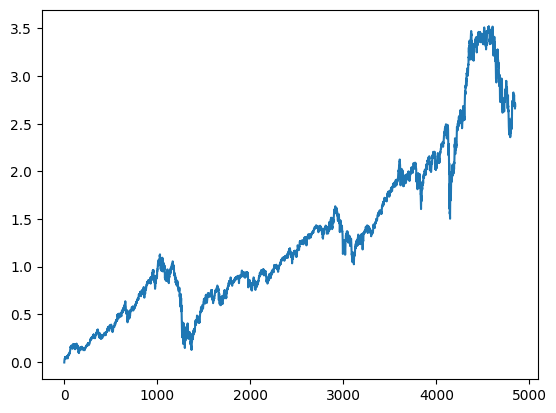

In [15]:
plt.plot(bt_numba_tuple[3])